In [56]:
import csv
import math
import sys, time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *

True


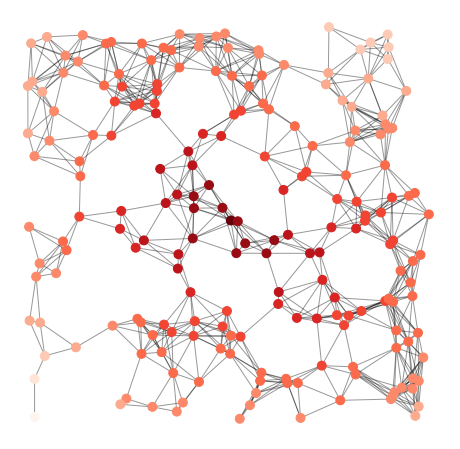

In [57]:
# Use seed when creating the graph for reproducibility
G = nx.random_geometric_graph(200, 0.125)

print(nx.is_connected(G))

if nx.is_connected(G)==False:
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy() 


# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, "pos")

# print(pos)

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(p.keys()),
    node_size=80,
    node_color=list(p.values()),
    cmap=plt.cm.Reds_r,
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()


site = {}

for node in G.nodes():
    site[node] = str(node)

for (u,v) in G.edges():
    if (u>v):
        u, v = v, u
    G.add_edge(u,v)
    G[u][v]['capa'] = np.random.random()*0.5 + 0.5 

n_demand = 50
K = nx.DiGraph()


for k in range(n_demand):
    nodeA = np.random.randint(200)
    while nodeA not in G.nodes():
        nodeA = np.random.randint(200)

    nodeB = np.random.randint(200)
    while nodeA == nodeB or nodeB not in G.nodes() :
        nodeB = np.random.randint(200)
        
    if nodeA > nodeB:
        tmp = nodeA
        nodeA = nodeB
        nodeB = tmp
        
    K.add_edge(nodeA,nodeB)                    
    # K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0 #Pour arriver à des taux de charges raisonnables
    K[nodeA][nodeB]['demand'] = np.clip(np.random.normal(0.5,1), a_min=0, a_max = 2)
    # print(float(row['demand'])



In [58]:
# G = nx.Graph()
# pos = {}
# site = {}

# # with open('nodes_cost266.csv', 'r') as f_node:
# with open('nodes_cost_2_commodity.csv', 'r') as f_node:
# # with open('w_node.csv', 'r') as f_node:
#     reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
#     for row in reader:
#         node = int(row['node'])
#         site_node = row['site']
#         x_coord = float(row['X'])
#         y_coord = float(row['Y'])
#         G.add_node(node,site=site_node)
#         pos[node] = [x_coord,y_coord]
#         site[node] = site_node

In [59]:
# # with open('edges_cost266.csv', 'r') as f_edge:
# with open('edges_cost_2_commodity.csv', 'r') as f_edge:
# # with open('w_edge.csv', 'r') as f_edge:
#     reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
#     for row in reader:
#         nodeA = int(row['nodeA'])
#         nodeB = int(row['nodeB'])
#         G.add_edge(nodeA,nodeB)        
#         G[nodeA][nodeB]['capa'] = float(row['capa'])

In [60]:
H = nx.DiGraph(G)
capa = {}

for (u,v) in G.edges():
    capa[(u,v)] = G[u][v]['capa']
    capa[(v,u)] = G[u][v]['capa']

In [61]:
# K = nx.DiGraph()

# # with open('demand_cost266.csv', 'r') as f_demand:
# with open('demand_2_commodity.csv', 'r') as f_demand:
# # with open('w_demand.csv', 'r') as f_demand:
#     reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
#     for row in reader:
#         nodeA = int(row['nodeA'])
#         nodeB = int(row['nodeB'])
#         if nodeA > nodeB:
#             tmp = nodeA
#             nodeA = nodeB
#             nodeB = tmp
            
#         K.add_edge(nodeA,nodeB)                    
#         # K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0 #Pour arriver à des taux de charges raisonnables
#         K[nodeA][nodeB]['demand'] = float(row['demand'])
#         # print(float(row['demand']))

In [62]:
print(len(G.nodes()),'nodes')
print(len(G.edges()),'edges')
print(len(K.edges()),'demands')

200 nodes
839 edges
50 demands


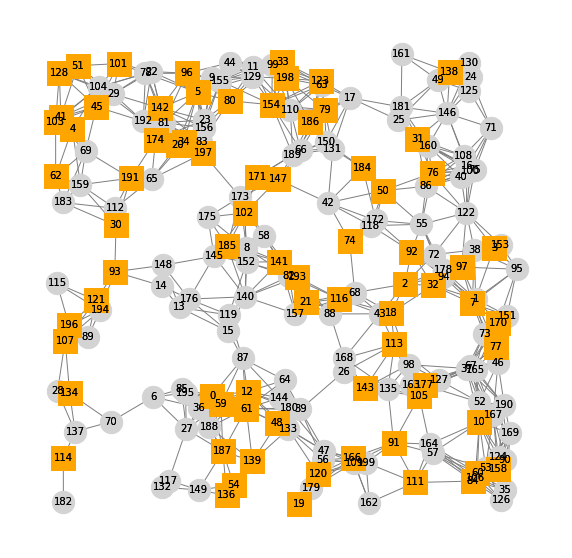

In [63]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')

nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')

In [64]:
# +++ Flow Conservation constraints +++
def flowConservation(model, node, o, d):
    inFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if j == node
    )
    outFlow = sum(
        model.flow[i, j, o, d]
        for (i, j) in model.arcs
        if i == node
    )
    if node == o:
        return (inFlow - outFlow + K[o][d]['demand'] == 0)
    elif node == d:
        return (inFlow - outFlow - K[o][d]['demand'] == 0)
    else:
        return (inFlow == outFlow)


In [65]:
#+++ Capacity constraints +++
def linkCapacity(model, i, j):
    expression = sum(model.flow[i,j,o,d] + model.flow[j,i,o,d] for (o,d) in model.demands)<= model.capa[i,j] * model.gamma
    return expression

In [66]:
solver = 'cplex'

print('>>> Loading optimization model')

model = ConcreteModel()

model.dual = Suffix(direction=Suffix.IMPORT)

model.nodes   = H.nodes()
model.links   = G.edges()
model.arcs    = H.edges()
model.demands = K.edges()

model.index1 = Set(initialize=[(u, o, d) for u in model.nodes for (o, d) in model.demands])
model.index2 = Set(initialize=[(u, v, o, d) for (u, v) in model.arcs for (o, d) in model.demands])

model.capa = Param(model.arcs, initialize=capa)

model.flow  = Var(model.index2, domain=NonNegativeReals)
model.gamma = Var(domain=NonNegativeReals)

model.objective = Objective(rule=lambda m: m.gamma, sense=minimize)

model.flowConserv = Constraint(model.index1, rule=flowConservation)

model.linkCapa = Constraint(model.links, rule=linkCapacity)


>>> Loading optimization model


In [67]:
print('>>> Solving optimization model')
    
# model.preprocess()

optim = SolverFactory(solver)
    
start_time = time.time()

results = optim.solve(model)
    
cpu_time = time.time() - start_time

print('+ TERM STAT:',results.solver.status)
print('+ TERM COND:',results.solver.termination_condition)
    
print('+ CPU  TIME = {0:.2f} s'.format(cpu_time))

if results.solver.status == SolverStatus.ok and results.solver.termination_condition != TerminationCondition.infeasible:
    print('+ OPT VAL  = {0:.8f}'.format(model.gamma.value))
    print('+ LWR BND  = {0:.2f}'.format(results.Problem._list[0]['Lower bound']))

>>> Solving optimization model
+ TERM STAT: ok
+ TERM COND: optimal
+ CPU  TIME = 5.94 s
+ OPT VAL  = 3.00198776
+ LWR BND  = 3.00


In [68]:
epsilon = 1.0e-06

load = {}
    
for (u,v) in G.edges():
    TotalFlow = 0.0
    for (o,d) in K.edges():
        TotalFlow += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow += model.flow[v,u,o,d].value
    G[u][v]['flow'] = TotalFlow    
    if TotalFlow > epsilon:
        load[(u,v)] = 100*TotalFlow/model.capa[(u,v)]
        # print(load[(u,v)])
        print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],load[(u,v)]))
        #print('link ({0:10s},{1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow,model.capa[(u,v)],100*TotalFlow/model.capa[(u,v)]))
    else:
        load[(u,v)] = 0.0

link (0         ,12        ):	flow = 1.756038 / capacity = 0.584958 -> load = 300.20 %
link (0         ,27        ):	flow = 2.110389 / capacity = 0.702997 -> load = 300.20 %
link (0         ,36        ):	flow = 2.999398 / capacity = 0.999137 -> load = 300.20 %
link (0         ,59        ):	flow = 1.883887 / capacity = 0.627546 -> load = 300.20 %
link (0         ,61        ):	flow = 2.409024 / capacity = 0.802476 -> load = 300.20 %
link (0         ,87        ):	flow = 1.918257 / capacity = 0.977353 -> load = 196.27 %
link (0         ,187       ):	flow = 2.019745 / capacity = 0.672803 -> load = 300.20 %
link (0         ,188       ):	flow = 1.963164 / capacity = 0.653955 -> load = 300.20 %
link (0         ,195       ):	flow = 1.886181 / capacity = 0.628311 -> load = 300.20 %
link (1         ,3         ):	flow = 1.778915 / capacity = 0.592579 -> load = 300.20 %
link (1         ,7         ):	flow = 2.506271 / capacity = 0.834870 -> load = 300.20 %
link (1         ,32        ):	flow = 0.4634

In [69]:
model.gamma.value
load1 = {}
G1 = G.copy()
Saturated_edge = []

print('____ Saturated Edges _____ ' )
for (u,v) in G1.edges():
    TotalFlow1 = 0.0
    for (o,d) in K.edges():
        TotalFlow1 += model.flow[u,v,o,d].value  #On somme pour chaque lien le flow qui passe
        TotalFlow1 += model.flow[v,u,o,d].value
    G1[u][v]['flow'] = TotalFlow1    
    if abs(100*TotalFlow1/model.capa[(u,v)] - model.gamma.value*100) < epsilon:
        Saturated_edge.append((u,v))
        load1[(u,v)] = 100*TotalFlow1/model.capa[(u,v)]
        print('link ({0:10s}, {1:10s}):\tflow = {2:8f} / capacity = {3:8f} -> load = {4:.2f} %'.format(site[u],site[v],TotalFlow1,model.capa[(u,v)],load1[(u,v)]))
        # model.capa[(u,v)] *= 0.9

# print(Saturated_edge)
def isSaturated(uv):
    isAttained = np.zeros(np.max(G.edges)+1)
    queue = collections.deque()
    u = uv[0]
    v = uv[1]
    isAttained[u] = 1
    for n in G.neighbors(u) : 
        if n not in queue and  abs(load[min(u,n), max(u,n)]  - model.gamma.value*100) > epsilon:
            queue.append(n)
    # for n in G.neighbors(u):
    #     if n not in queue:
    #         queue.append(n)
    while isAttained[v] == 0 and len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        for n1 in G.neighbors(n) :
            if (n1 not in queue) and (isAttained[n1] == 0) and abs(load[min(n,n1), max(n,n1)]  - model.gamma.value*100) > epsilon:
                queue.append(n1)
    return isAttained[v] == 0 

critical_edge = []
for uv in Saturated_edge : 
    # print(isSaturated(uv))
    if isSaturated(uv):
        critical_edge.append(uv)
print('')
print('_____ Critical Edges ____')
for (u,v) in critical_edge:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v))
# print([site[critical_edge[k][0]] + ' -> ' + site[critical_edge[k][1]] for k in range(len(critical_edge))])


____ Saturated Edges _____ 
link (0         , 12        ):	flow = 1.756038 / capacity = 0.584958 -> load = 300.20 %
link (0         , 27        ):	flow = 2.110389 / capacity = 0.702997 -> load = 300.20 %
link (0         , 36        ):	flow = 2.999398 / capacity = 0.999137 -> load = 300.20 %
link (0         , 59        ):	flow = 1.883887 / capacity = 0.627546 -> load = 300.20 %
link (0         , 61        ):	flow = 2.409024 / capacity = 0.802476 -> load = 300.20 %
link (0         , 187       ):	flow = 2.019745 / capacity = 0.672803 -> load = 300.20 %
link (0         , 188       ):	flow = 1.963164 / capacity = 0.653955 -> load = 300.20 %
link (0         , 195       ):	flow = 1.886181 / capacity = 0.628311 -> load = 300.20 %
link (1         , 3         ):	flow = 1.778915 / capacity = 0.592579 -> load = 300.20 %
link (1         , 7         ):	flow = 2.506271 / capacity = 0.834870 -> load = 300.20 %
link (1         , 38        ):	flow = 2.946554 / capacity = 0.981534 -> load = 300.20 %
link

In [70]:
for (o,d) in K.edges():
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
    # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
    for (u,v) in model.arcs:
        if model.flow[u,v,o,d].value > epsilon:
            # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
            print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))


demand (3,54): 2.672436
	arc (1,170): flow = 0.521872
	arc (2,18): flow = 0.549518
	arc (2,43): flow = 0.368350
	arc (3,1): flow = 0.015601
	arc (3,38): flow = 0.674075
	arc (3,122): flow = 0.200546
	arc (7,1): flow = 0.506271
	arc (10,124): flow = 0.521872
	arc (18,2): flow = 0.549518
	arc (26,39): flow = 0.368350
	arc (35,84): flow = 0.521872
	arc (37,105): flow = 1.344581
	arc (38,7): flow = 0.506271
	arc (38,122): flow = 0.167804
	arc (39,48): flow = 0.890222
	arc (43,113): flow = 0.368350
	arc (47,39): flow = 0.521872
	arc (48,139): flow = 0.890222
	arc (52,10): flow = 0.521872
	arc (53,35): flow = 0.521872
	arc (55,178): flow = 0.368350
	arc (67,52): flow = 0.521872
	arc (84,111): flow = 0.521872
	arc (105,37): flow = 1.344581
	arc (111,199): flow = 0.521872
	arc (113,26): flow = 0.368350
	arc (122,55): flow = 0.368350
	arc (124,53): flow = 0.521872
	arc (136,54): flow = 0.890222
	arc (139,136): flow = 0.890222
	arc (170,67): flow = 0.521872
	arc (178,2): flow = 0.368350
	arc (19

In [71]:
criticalSources = []
criticalDemands = []

def getCriticalSources():
    # criticalSource = []
    criticalNodes = []
    criticalDemand = []
    # criticalDestination = []
    for (o,d) in K.edges():
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']*model.gamma.value))
        # print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))
        bool = False
        for (u,v) in model.arcs:
            if (min(u,v), max(u,v)) in critical_edge and model.flow[u,v,o,d].value > epsilon:
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value/model.gamma.value))
                # print('\tarc ({0:s},{1:s}): flow = {2:f}'.format(site[u],site[v],model.flow[u,v,o,d].value))
                bool = True
        if (bool):
            criticalDemand.append((o,d))
            if o not in criticalNodes :
                criticalNodes.append(o)
            if d not in criticalNodes:
                criticalNodes.append(d)
    return criticalDemand, criticalNodes

criticalDemands, criticalNodes= getCriticalSources()

print(criticalNodes)


print('_____ Critical Demands _____')
for (o,d) in criticalDemands : 
    print('demand ({0:s},{1:s}): {2:f}'.format(site[o],site[d],K[o][d]['demand']))



[54, 79, 134, 77, 128, 4, 12, 171, 59, 138, 141, 154, 187, 103, 196, 34, 116, 186, 61, 121, 93, 198, 107, 143, 105, 18, 41]
_____ Critical Demands _____
demand (54,79): 0.845054
demand (54,134): 1.229312
demand (77,128): 2.000000
demand (4,12): 1.760441
demand (79,171): 0.660968
demand (59,79): 1.163418
demand (138,141): 1.946104
demand (154,187): 0.000000
demand (103,196): 0.998484
demand (34,116): 1.870762
demand (116,186): 0.003419
demand (61,121): 1.578958
demand (93,198): 1.290923
demand (107,143): 2.000000
demand (105,107): 1.325050
demand (18,41): 1.107615


In [72]:
def getSameSideNodes(node):
    sameSideNodes = [node]
    isAttained = np.zeros(np.max(G.edges) + 1)
    criticalChoosenEdges = []
    queue = collections.deque()
    u = node
    # print(u)
    isAttained[u] = 1
    for n in G.neighbors(u) : 
        if n not in queue :
            if (min(n,u), max(n,u)) not in critical_edge :
                queue.append(n)
            else :
                if (min(n,u), max(n,u)) not in criticalChoosenEdges:
                        criticalChoosenEdges.append((min(n,u), max(n,u)))
                        # print((min(n,u), max(n,u)) in critical_edge)

    # for n in G.neighbors(u):
    #     if n not in queue:
    #         queue.append(n)
    while len(queue) != 0:
        n = queue.popleft()
        isAttained[n] = 1
        # if n in criticalSources : 
        sameSideNodes.append(n)
        for n1 in G.neighbors(n) :
            if (n1 not in queue) and (isAttained[n1] == 0) :
                if (min(n,n1), max(n,n1)) not in critical_edge :
                    queue.append(n1)
                else :
                    if (min(n,n1), max(n,n1)) not in criticalChoosenEdges:
                        criticalChoosenEdges.append((min(n,n1), max(n,n1)))
                        # print((min(n,n1), max(n,n1)) in critical_edge)
    return sameSideNodes, criticalChoosenEdges


def minCut() : 
    min = np.infty
    minCap = 0
    minDemand = 0
    tableSameSideNodes = []
    tableCriticalChoosenEdges =[]
    for node in criticalNodes:
        # table = np.array(tableSameSideNodes).flatten()
        # print(table)
        if node not in [j for l in tableSameSideNodes for j in l]:
            sameSideNodes, criticalChoosenEdges = getSameSideNodes(node)
            demand = 0
            for n in sameSideNodes:
                for (o,d) in criticalDemands :
                    if (n == o) or n == d:
                        demand += K[o][d]['demand']
            capacity = 0
            
            for (u,v) in criticalChoosenEdges:
                capacity += G[u][v]['capa']
            if (min > capacity/demand):
                min = capacity / demand
                minCap = capacity
                minDemand = demand
                tableSameSideNodes = [sameSideNodes]
                tableCriticalChoosenEdges = [criticalChoosenEdges]
            elif ( capacity/demand == min):
                tableSameSideNodes.append(sameSideNodes)
                tableCriticalChoosenEdges.append(criticalChoosenEdges)
        
    # print(minDemand)
    # print(minCap)
    return min, tableSameSideNodes, tableCriticalChoosenEdges

mincut,  tableSameSideNodes, tableCriticalChoosenEdges = minCut()

print('')
print('_____ Critical Choosen Edges _____')
criticalChoosenEdges = tableCriticalChoosenEdges[0] # We consider the first solution
for (u,v) in criticalChoosenEdges:
    print('link ({0:10s}, {1:10s})\t'.format(site[u],site[v]),'site 1 = '+ str(u)+ ', site 2 = ' + str(v), ', capa = ', G[u][v]['capa'])
# print(criticalChoosenEdges)


# print(sameSideNodes)
print("")
print('mincut = ', mincut)
print('maxflow = ', 1/model.gamma.value)

# print("")
print('nombre de solutions optimales trouvées :', len(tableSameSideNodes))


_____ Critical Choosen Edges _____
link (6         , 70        )	 site 1 = 6, site 2 = 70 , capa =  0.8303905953226113
link (14        , 93        )	 site 1 = 14, site 2 = 93 , capa =  0.8353530286796387
link (93        , 148       )	 site 1 = 93, site 2 = 148 , capa =  0.5344379715640469
link (102       , 147       )	 site 1 = 102, site 2 = 147 , capa =  0.6181106777556564
link (147       , 173       )	 site 1 = 147, site 2 = 173 , capa =  0.6718874956222081
link (147       , 171       )	 site 1 = 147, site 2 = 171 , capa =  0.523194402993501
link (66        , 147       )	 site 1 = 66, site 2 = 147 , capa =  0.824300661162717
link (147       , 189       )	 site 1 = 147, site 2 = 189 , capa =  0.5017255608713311
link (42        , 147       )	 site 1 = 42, site 2 = 147 , capa =  0.5081974344248218
link (30        , 93        )	 site 1 = 30, site 2 = 93 , capa =  0.6074875562675908

mincut =  0.20730378777611191
maxflow =  0.3331126177097216
nombre de solutions optimales trouvées : 1


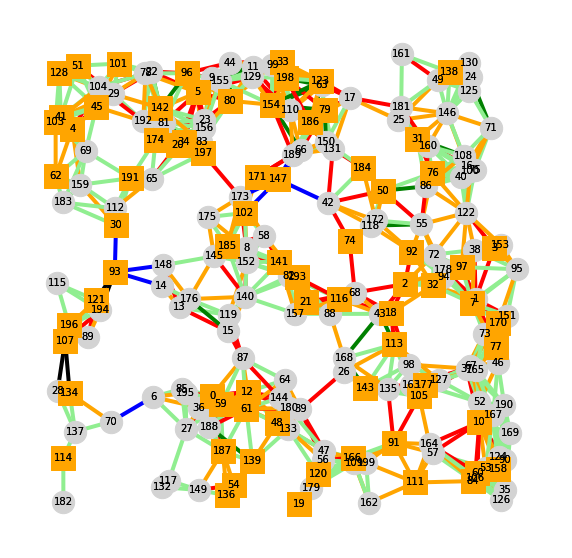

In [73]:
plt.figure(figsize=(10,10));
plt.axis('off')

colors = []
for (u,v) in G.edges():
    if (u,v) in criticalChoosenEdges:
        colors.append('blue')
    # elif load[(u,v)] > 100:
    #     colors.append('black')
    elif (u,v) in critical_edge:
         colors.append('black')
    elif load[(u,v)] > model.gamma.value *100 - epsilon:
        colors.append('red')
    elif load[(u,v)] > 50:
        colors.append('orange')
    elif load[(u,v)] >=25:
        colors.append('green')
    elif load[(u,v)] >=0:
        colors.append('lightgreen')
    else:
        colors.append('lightgrey')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color=colors, width=4)

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')